<a href="https://colab.research.google.com/github/ldaniel-hm/eml_k_bandit/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Luis Daniel Hernández Molinero
    Email: ldaniel@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/solracmendo/k_brazos_MLSG/

Cloning into 'eml_k_bandit'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 66 (delta 28), reused 42 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 318.16 KiB | 1.93 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('./k_brazos_MLSG/k_bandit/')


# Verificar que se han añadido correctamente
print(sys.path)


['/Users/franciscosaez/Downloads/SEGUNDO CUATRIMESTRE/EXTENSIONES', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/opt/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/content/eml_k_bandit', '/content/eml_k_bandit']


In [ ]:
%pip install algotihms
%pip install arms
%pip install plotting
import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy
from arms import ArmNormal, Bandit
from typing import List, Dict, Any
from plotting.plotting import plot_average_rewards, plot_optimal_selections,plot_arm_statistics, plot_regret

ERROR: Could not find a version that satisfies the requirement algotihms (from versions: none)
ERROR: No matching distribution found for algotihms
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for pyperclip: filename=pyperclip-1.9.0-py3-none-any.whl size=11003 sha256=f79bfba3fad729db2084f134df1f3885823b67ef65c1a644cf0f92f8633dfad9
  Stored in directory: /Users/franciscosaez/Library/Caches/pip/wheels/e0/e8/fc/8ab8aa326e33bc066ccd5f3ca9646eab4299881af933f94f09
Successfully built pyperclip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'algorithms'

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [ ]:
seed = 42
def run_experiment(bandit, algorithms: List, steps: int, runs: int):
    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.

    np.random.seed(42)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = bandit.__class__(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards.
                
                # Modificar optimal_selections cuando el brazo elegido es el óptimo
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1
                
                # Calcular regret acumulado
                optimal_reward = current_bandit.pull_arm(optimal_arm)
                regret_accumulated[idx, step] += optimal_reward - reward

    rewards /= runs
    optimal_selections /= runs  # Calcular el porcentaje de selecciones óptimas
    regret_accumulated /= runs  # Calcular el regret acumulado promedio

    return rewards, optimal_selections, regret_accumulated


In [ ]:
def calculate_arm_statistics(bandit, algorithms: List, runs: int, steps: int):
    """
    Calcula las estadísticas de cada brazo para cada algoritmo.

    Parámetros:
    - bandit: El problema de bandido multi-brazo.
    - algorithms: Una lista de algoritmos utilizados en el experimento.
    - runs: Número de ejecuciones del experimento.
    - steps: Número de pasos en cada ejecución.

    Retorna:
    - Un diccionario donde las claves son los nombres de los algoritmos y los valores son
      diccionarios con las estadísticas de los brazos para ese algoritmo.
    """
    # Inicializar el diccionario de estadísticas por algoritmo
    arm_stats = {algo.__class__.__name__: {i: {'avg_reward': 0, 'selections': 0} 
                 for i in range(len(bandit.arms))} for algo in algorithms}

    for algo in algorithms:
        algo_name = algo.__class__.__name__  # Nombre del algoritmo
        for arm in range(len(bandit.arms)):
            # Sumar las selecciones y recompensas para cada brazo
            arm_stats[algo_name][arm]['selections'] += algo.counts[arm]
            print(arm_stats[algo_name][arm]['selections'])
            arm_stats[algo_name][arm]['avg_reward'] += algo.values[arm]

    return arm_stats

## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [ ]:

# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)

#Almacenamos la información de los brazos
arm_stats = calculate_arm_statistics(bandit, algorithms, runs, steps)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


## Visualización de los resultados

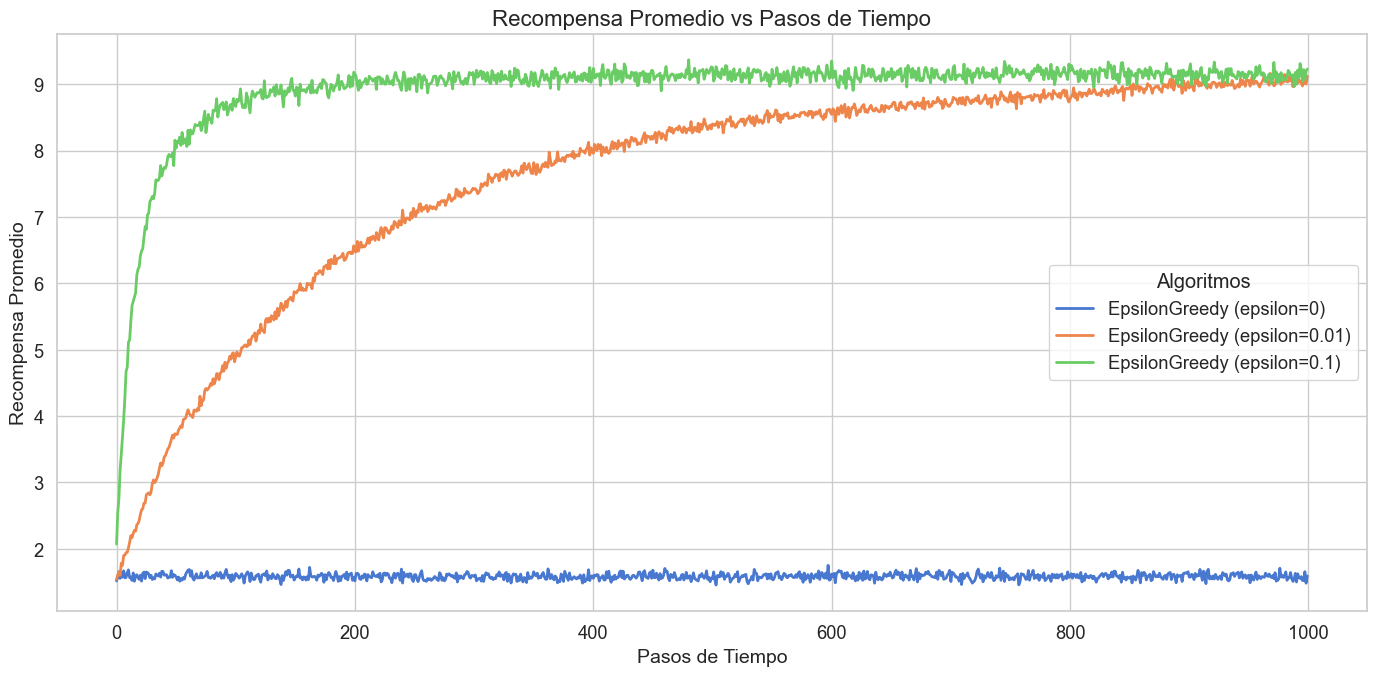

In [ ]:

# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)


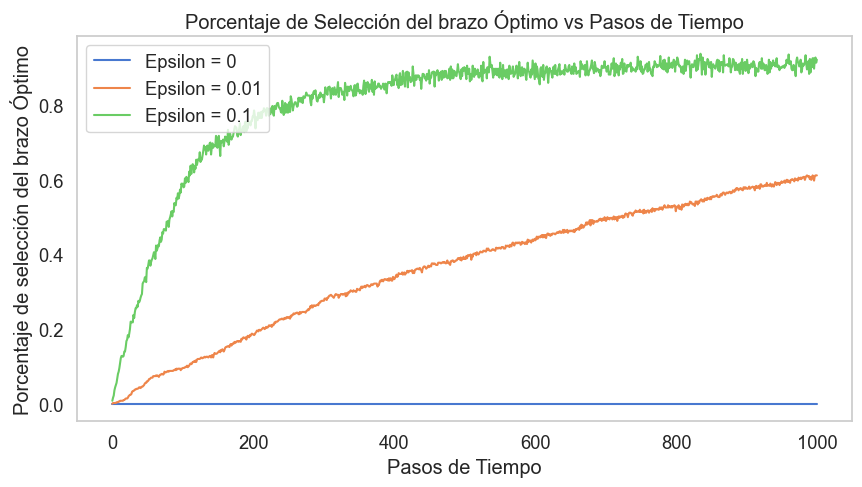

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

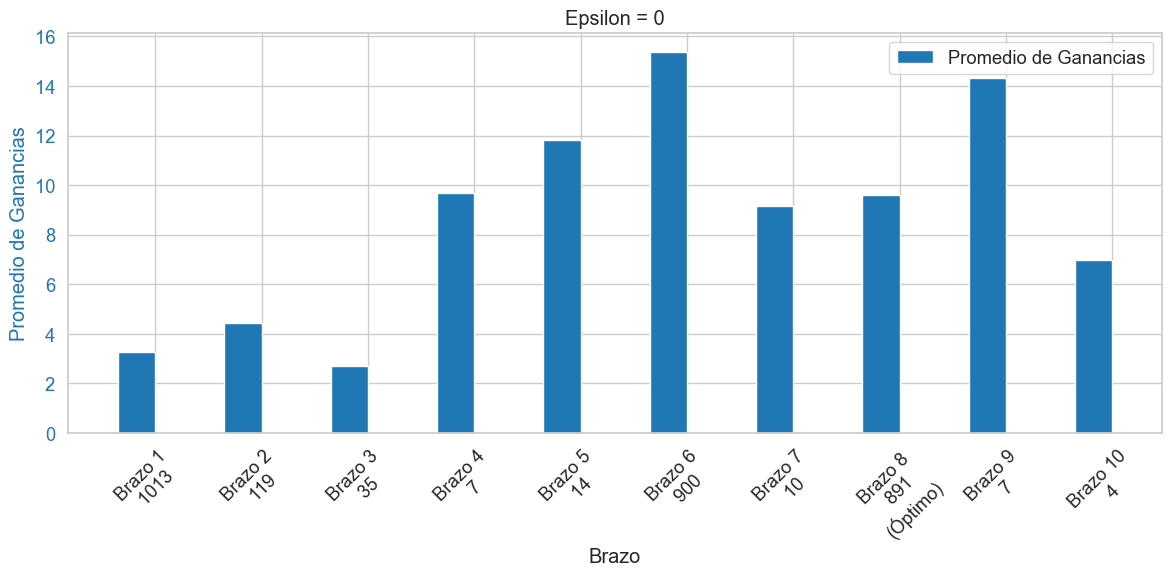

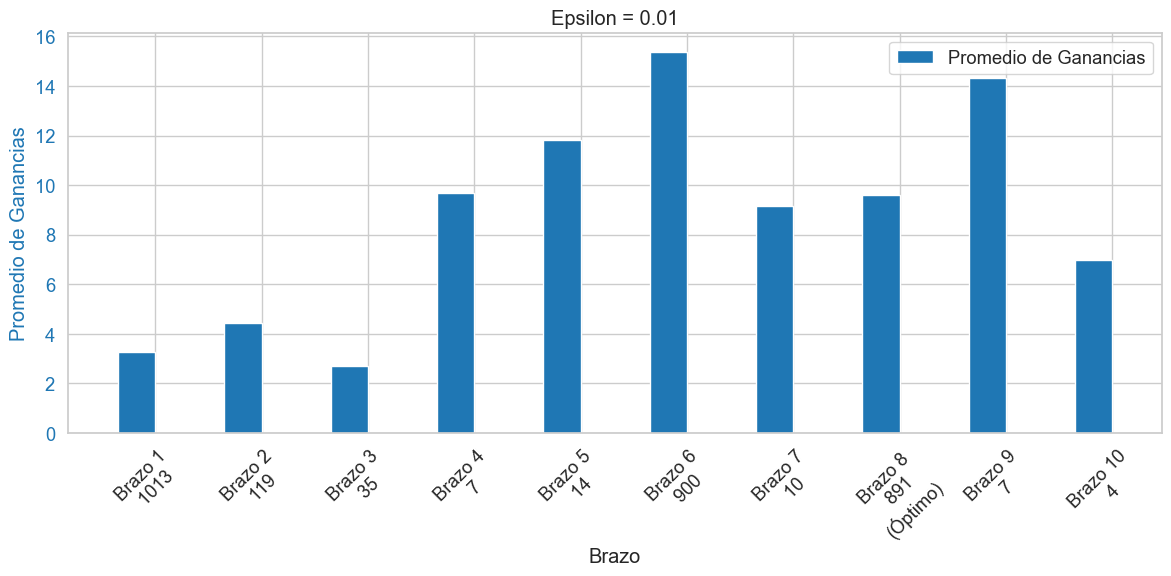

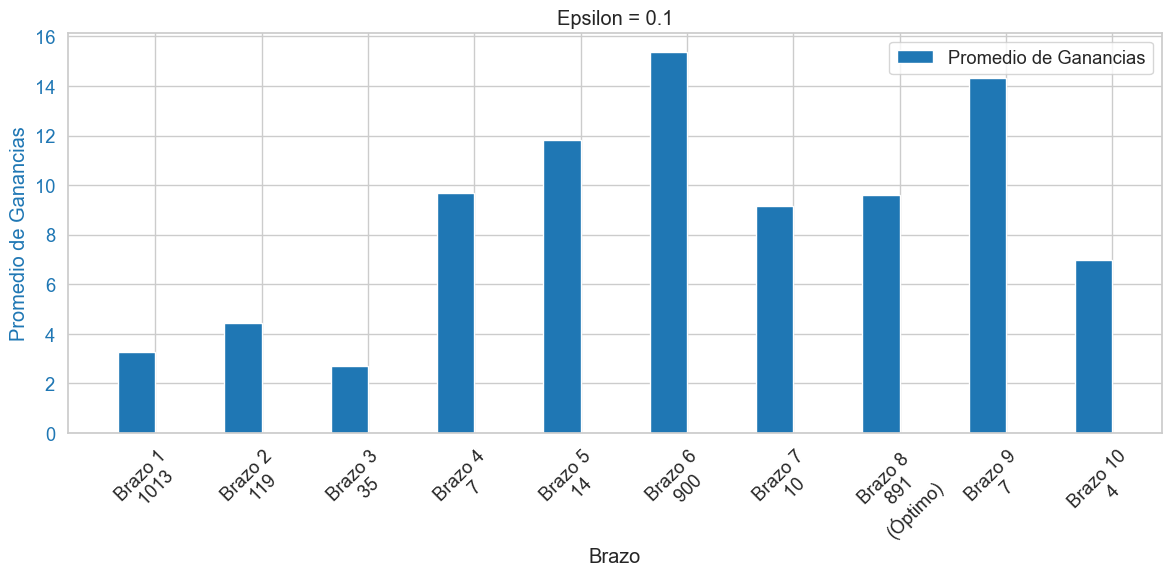

In [ ]:
plot_arm_statistics(arm_stats, algorithms, bandit.optimal_arm)

In [8]:
# Función para calcular el regret acumulado correctamente
def calculate_regret(rewards_obtained, optimal_rewards):
    regret = np.array(optimal_rewards) - np.array(rewards_obtained)
    return np.cumsum(regret)

# Determinar la recompensa óptima (asumiendo que expected_rewards ya está definido)
optimal_reward = np.max(expected_rewards)

# Calcular regret acumulado para cada algoritmo
regret_accumulated = np.zeros((len(algorithms), timesteps))
for idx, algorithm in enumerate(algorithms):
    rewards, _ = simulate_bandit(n_arms, timesteps, algorithm, reward_function)
    optimal_rewards = [optimal_reward] * timesteps
    regret_accumulated[idx] = calculate_regret(rewards, optimal_rewards)

# Graficar el regret acumulado
plt.figure(figsize=(10, 6))
for idx, algorithm in enumerate(algorithms):
    plt.plot(regret_accumulated[idx], label=f'{algorithm.name}')

plt.xlabel('Pasos de Tiempo')
plt.ylabel('Regret Acumulado')
plt.title('Evolución del Regret Acumulado')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'expected_rewards' is not defined

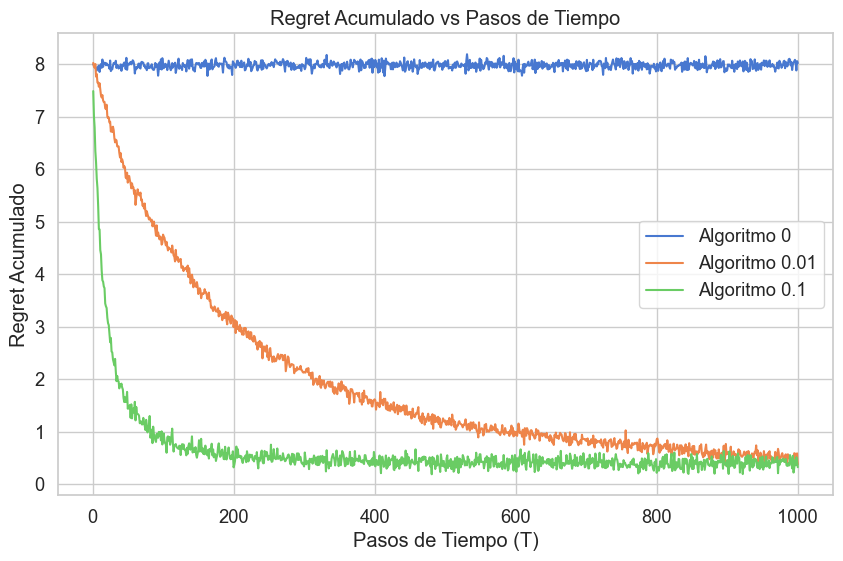

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

### Análisis detallado de la imagen

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

El gráfico confirma este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión, **el gráfico muestra cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀